# CSE 152A: Discussion Week 8 and 9: PyTorch Tutorials
Adapted from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## **Part 0: Set-up**
### First, lets import PyTorch and some useful functions/objects

In [1]:
import torch # Main torch package
from torch import nn # Importing specifically the nn class of the torch library, this will make our code more consise later on
from torch.utils.data import DataLoader # Importing the DataLoader class
from torchvision import datasets # Used for importing built-in datasets
from torchvision.transforms import ToTensor # Used to transform data to tensors (the main object in PyTorch)
import matplotlib.pyplot as plt # Plotting
import numpy as np
from tqdm import tqdm # Progress bar

###  Let's specify a variable to use GPU if available and CPU if not. CUDA is the API for working with NVIDIA GPUs. There is good support in Pytorch to work with CUDA and NVIDIA GPUs.

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"The device currently available is: {device}")
!nvidia-smi # This will show information about your GPU if there is one available

The device currently available is: cpu
/bin/bash: nvidia-smi: command not found


### If you have "cpu", then it means that there is no GPU currently available that CUDA can find. This is because in Google Colab, we need to activate it.

**NOTE: There is a time limit for GPU usage per day. If you reach this time limit while doing the HW, we do NOT expect you to purchase a subscription to Colab Pro. Please just save your notebook and copy it over to another Gmail account and work on it there while your school Google account is on cooldown.**

### To activate it, we can click at the top: Runtime -> Change Runtime Type -> Select T4 GPU under the Hardware Accelerator selection. You will probably need to run your cells again.

### At this point, you should hopefully see that the device currently available is cuda!

### **Tensors**

The main object in PyTorch are tensors, similar to Numpy ndarrays. Main difference is PyTorch has built-in GPU/hardware acceleration support. You can also easily switch between PyTorch tensors and Numpy ndarrays.

[Bridging Numpy and PyTorch](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#bridge-to-np-label)

In [3]:
# Initializing a tensor
data = torch.tensor([
    [1,2],
    [3,4]
])
print(data)
print(data.shape)
print()

# Starting with a numpy array
np_arr = np.array([
    [1,2],
    [3,4]
])
data = torch.tensor(np_arr)
print(data)
print(data.shape)
print()

# And switch back
np_arr = data.numpy()
print(np_arr)
print(np_arr.shape)
print()

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])

[[1 2]
 [3 4]]
(2, 2)



## **Part 1: Initializing your dataset**
### Your dataset will determine some of how your network needs to be set-up. There are two main objects you need to set-up: the Dataset and DataLoader. Pytorch has a few datasets built into it, so we will use the CIFAR-10 dataset for this tutorial. You can read more in the tutorials about how to initialize your own Dataset and Dataloaders for custom data.

Files already downloaded and verified
Files already downloaded and verified
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64
This image is of class 8


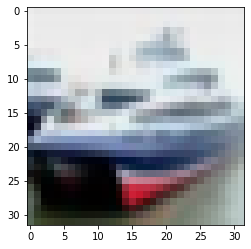

In [4]:
# Download datasets
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

for X,y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    plt.imshow(X[1,:,:,:].permute(1,2,0)) # Show an image from our dataset
    print(f"This image is of class {y[1]}")
    break

### At this point, we have downloaded our data and set-up our data loaders. You can see that we can do .shape on these tensor objects just like Numpy, however note the dimensions are probably not in the order you are expecting. Here, we have shape (batch_size, channels, height, width). Channels is the third dimension of your images (think RGB). Height and width are specified last in the dimensions. Many PyTorch functions *expect* the input to be this way.

## **Part 2: Defining your network**

### Each network/layer in PyTorch should be defined inside of a class that inherits from nn.Module. There are then two things we need to do: Initialize the layers inside of the constructor, and specify how data should pass through the network in the forward function.

### I have intentionally created a small and simple network to get the PyTorch concepts across and will obtain somewhat poor accuracy. In HW4, we will improve upon this.

[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

[Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)


In [5]:
class MyNetwork(nn.Module):
    def __init__(self):
        """
        This is the constructor of our neural network. Inside of it, we should
        specify all of the layers that are used to build the model.

        Lets say that we want to create a network with 1 convolutional layer
        and 2 fully-connected layers. For now:

        1. Conv2d: 16 output channels, kernel of size 3, 1 padding, 1 stride (takes the image data as input)
        2. Linear: 128 output features
        3. Linear: 10 output features (This is produces our output)

        With ReLU activation function after each convolutional and linear layer.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # Convolutional layer 1: in_channels depends on input data
        self.fc1 = nn.Linear(16*32*32, 128) # Fully connected layer 1: Must flatten tensor from conv1 before passing to fc1 (in_features)
        self.fc2 = nn.Linear(128, 10) # Fully connected layer 2: in_features only depends on fc1

        self.relu = nn.ReLU() # ReLU activation function (can be used multiple times since no parameters)
        self.flatten = nn.Flatten() # Used for flattening the tensor for fc layers

    def forward(self, x):
        """
        Here, we should specify how our takes in our input data x
        and feeds it through the network. In this case, x will
        be the images obtained from the data loader (tensors).
        """
        out1 = self.relu(self.conv1(x)) # pass into first conv layer

        flat = self.flatten(out1)
        out2 = self.relu(self.fc1(flat))
        out3 = self.fc2(out2)

        return out3 # Note: We do not need to apply an activation function to the output of the network


# Now we can instantiate a network:
model = MyNetwork() # Create/Initialze the model
model.to(device) # Send the model to the device we've chosen (either GPU or CPU depending on what's available)
print(model)

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


## **Part 3: Training and Evaluating**

After we've set-up our network, they currently have randomly initialized weights. We need to optimize the network for our problem (classification). So, we need to decide on our loss function, the optimizer we will use, and then just feed our data through.

[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [6]:
loss_fn = nn.CrossEntropyLoss() # Initialize our loss function
optimizer = torch.optim.Adam(model.parameters()) # Initialize our optimizer -- we pass in the parameters that we want to optimize

def train(dataloader, model, loss_fn, optimizer, device):
  """
  This function will perform the optimization/training of the network
  """
  size = len(dataloader.dataset) # Grab the total number of images
  model.train() # Set the model to training mode (parameters can be updated and gradients are calculated)
  optimizer.zero_grad() # Just make sure that the gradients are zero at the beginning
  loss_history = []

  # Now, we loop over our training data, pass in a batch, calculate the loss,
  # calculate gradients, and update the our weights through the optimizer
  for batch, (X, y) in enumerate(dataloader):

    # First, we need to move the data to the same device as the model
    # Ideally, everything is done on GPU
    X, y = X.to(device), y.to(device)

    # Then, we can just pass the data through the model (forward)
    # and calculate the loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Now, we can calculate the gradients through backpropagation
    loss.backward()

    # Take a step along the direction of the gradient (minimize)
    optimizer.step()

    # Zero out the gradients
    optimizer.zero_grad()

    # Logging
    loss, current = loss.item(), (batch+1)*len(X)
    if batch % 100 == 0:
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    loss_history.append(loss)

  return loss_history

def test(dataloader, model, loss_fn, device):
  """
  This function will test/evaluate our network after training
  """
  size = len(dataloader.dataset) # Grab the total number of images
  num_batches = len(dataloader) # Grab the total number of batches
  model.eval() # Set the network to eval mode
  test_loss, correct = 0.0, 0.0
  with torch.no_grad(): # Ensure we do not calculate gradients
    for X, y in dataloader:

      # Send data to same device as model
      X, y = X.to(device), y.to(device)

      # Pass the data through the model
      pred = model(X)

      # Compute the loss on the test set
      test_loss += loss_fn(pred, y).item()

      # Compute the number of correct predictions
      correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

  # Get the average test loss
  test_loss /= num_batches

  # Compute the accuracy
  acc = correct / size

  print(f"\nTest Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
# Now, we can just call the functions we've written

# Training
train_loss = train(train_dataloader, model, loss_fn, optimizer, device)

# Testing
test(test_dataloader, model, loss_fn, device)

loss: 2.292480  [   64/50000]
loss: 1.847973  [ 6464/50000]
loss: 1.425559  [12864/50000]
loss: 1.551505  [19264/50000]
loss: 1.490573  [25664/50000]
loss: 1.633134  [32064/50000]
loss: 1.544008  [38464/50000]
loss: 1.469622  [44864/50000]

Test Error: 
 Accuracy: 50.8%, Avg loss: 1.355355 



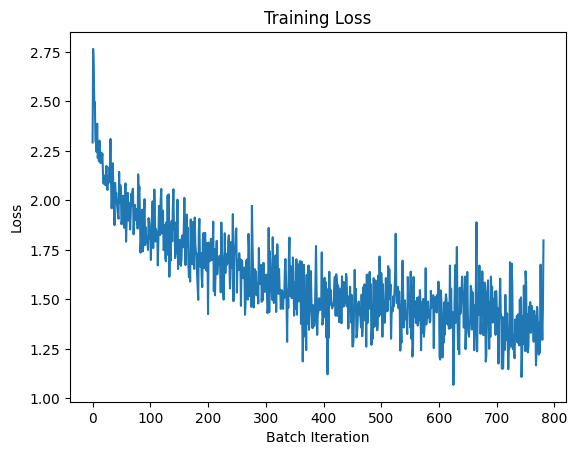

In [8]:
# Now, we can plot our training loss
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Batch Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## At this point, lets take a detour and talk about gradients and backpropagation.

Let's take a simple function

$$
f(x,w,b) = wx + b
$$

Starting with values $x=3$, $w=4$, $b=2$, let's find how to update the parameters $w,b$:

<br>

Using standard gradient descent's update rule, we want to find:
$$
w_{n+1} = w_n - \eta * \frac{δf}{δw}
$$

$$
b_{n+1} = b_n - \eta * \frac{δf}{δb}
$$

We can turn this into a computational graph:

![Computational Graph](https://drive.google.com/uc?export=view&id=1cPiGgsfR4NG1iJHrAANfJ5KloyoXKe41)



In [5]:
# Show this result in code!
x = torch.tensor([3.,2.,1.])
w = torch.tensor([4.,2.,1.])
b = torch.tensor([2.])

## gradients are required.
(x.requires_grad_())
(w.requires_grad_())
(b.requires_grad_())

## forward pass.
f = torch.sum(w*x) + b

## backward pass
f.backward()

print(f"x: {x.detach()}, grad of x: {x.grad}")
print(f"w: {w.detach()}, grad of w: {w.grad}")
print(f"b: {b.detach()}, grad of b: {b.grad}")

x: tensor([3., 2., 1.]), grad of x: tensor([4., 2., 1.])
w: tensor([4., 2., 1.]), grad of w: tensor([3., 2., 1.])
b: tensor([2.]), grad of b: tensor([1.])


## We have now completed a quick-start tutorial on creating a CNN and training it! Let's briefly talk about gradient calculation in PyTorch.

### Autograd

### Now we can briefly discuss automatic differentiation and gradients. Remember the loss_fn.backward()? This calculated the gradients of each parameter in our network using *backpropagation* (we will discuss this in lecture). PyTorch has automatic differentiation built-in to it.
[Automatic differentiation with autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

## Let's look a little deeper into our code
First, let's look at the shape of our data as it passes through each layer in our network.

In [6]:
class MyNetwork2(nn.Module):
    def __init__(self):
        """
        This is the constructor of our neural network. Inside of it, we should
        specify all of the layers that are used to build the model.

        Lets say that we want to create a network with 1 convolutional layer
        and 2 fully-connected layers. For now:

        1. Conv2d: 16 output channels, kernel of size 3, 1 padding, 1 stride (takes the image data as input)
        2. Linear: 128 output features
        3. Linear: 10 output features (This is produces our output)

        With ReLU activation function after each convolutional and linear layer.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # Convolutional layer 1: in_channels depends on input data
        self.fc1 = nn.Linear(16*32*32, 128) # Fully connected layer 1: Must flatten tensor from conv1 before passing to fc1 (in_features)
        self.fc2 = nn.Linear(128, 10) # Fully connected layer 2: in_features only depends on fc1

        self.relu = nn.ReLU() # ReLU activation function (can be used multiple times since no parameters)
        self.flatten = nn.Flatten() # Used for flattening the tensor for fc layers

    def forward(self, x):
        """
        Here, we should specify how our takes in our input data x
        and feeds it through the network. In this case, x will
        be the images obtained from the data loader (tensors).
        """
        out1 = self.conv1(x)
        print(f"Shape after conv1: {out1.shape}")
        out1 = self.relu(out1)
        print(f"Shape after relu: {out1.shape}")


        flat = self.flatten(out1)
        print(f"Shape after flatten: {flat.shape}")
        out2 = self.fc1(flat)
        print(f"Shape after fc1: {out2.shape}")
        out2 = self.relu(out2)
        print(f"Shape after relu: {out2.shape}")
        out3 = self.fc2(out2)
        print(f"Shape after fc2: {out3.shape}")

        return out3 # Note: We do not need to apply an activation function to the output of the network


# Now we can instantiate a network:
model = MyNetwork2() # Create/Initialze the model
model.to(device) # Send the model to the device we've chosen (either GPU or CPU depending on what's available)
print(model)

MyNetwork2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [7]:
# Create a fake batch of data
# Remember, we will be passing in batches of data
# Data shape: (batch_size, channels, height, width)

# Following the shape of the CIFAR10 data, lets make
# a tensor full of zeros
X = torch.zeros((2, 3, 32, 32)).to(device)
print(X.shape)

torch.Size([2, 3, 32, 32])


In [8]:
# Now, lets pass it into our network and see the shapes at each point
out = model(X)

Shape after conv1: torch.Size([2, 16, 32, 32])
Shape after relu: torch.Size([2, 16, 32, 32])
Shape after flatten: torch.Size([2, 16384])
Shape after fc1: torch.Size([2, 128])
Shape after relu: torch.Size([2, 128])
Shape after fc2: torch.Size([2, 10])


### This is one way to track the shapes of your data. If you recieve shape errors at some point, it might be helpful to do this throughout your forward function to figure out if things are as you expect. Some layers like Conv2d and MaxPool2d, actually modify the height and width of the input data. You should refer to the equations in the documentation to calculate it directly. For parameters you didn't specify, you should just use the default values specified in the function signature. Lets look at Conv2d for example.

[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

### The previous network we created was designed specifically so that the convolutional layers didn't affect the height and width. Let's look at another example where this is not the case.

In [9]:
class MyNetwork3(nn.Module):
    def __init__(self):
        """
        Previously, the convolutional layer maintained the original height and width of the data.
        Here, we're going to show another network where the convolutional layers affect the height and width
        of our data.

        1. Conv2d: 16 output channels, kernel of size 3, 0 padding, 1 stride
        2. Conv2d: 32 output channels, kernel of size 3, 0 padding, 1 stride
        3. Linear: 128 output features
        4. Linear: 10 output features (This is produces our output)

        With ReLU activation function after each convolutional and linear layer.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=0)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=0)

        self.fc1 = nn.Linear(32*28*28, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU() # ReLU activation function (can be used multiple times since no parameters)
        self.flatten = nn.Flatten() # Used for flattening the tensor for fc layers

    def forward(self, x):
        """
        Here, we should specify how our takes in our input data x
        and feeds it through the network. In this case, x will
        be the images obtained from the data loader (tensors).
        """
        out = self.conv1(x)
        print(f"Shape after conv1: {out.shape}")
        out = self.relu(out)
        print(f"Shape after relu: {out.shape}")

        out = self.conv2(out)
        print(f"Shape after conv2: {out.shape}")
        out = self.relu(out)
        print(f"Shape after relu: {out.shape}")


        out = self.flatten(out)
        print(f"Shape after flatten: {out.shape}")
        out = self.fc1(out)
        print(f"Shape after fc1: {out.shape}")
        out = self.relu(out)
        print(f"Shape after relu: {out.shape}")
        out = self.fc2(out)
        print(f"Shape after fc2: {out.shape}")

        return out # Note: We do not need to apply an activation function to the output of the network


# Now we can instantiate a network:
model = MyNetwork3() # Create/Initialze the model
model.to(device) # Send the model to the device we've chosen (either GPU or CPU depending on what's available)
print(model)

MyNetwork3(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [10]:
# Now, lets pass it into our network and see the shapes at each point
out = model(X)

Shape after conv1: torch.Size([2, 16, 30, 30])
Shape after relu: torch.Size([2, 16, 30, 30])
Shape after conv2: torch.Size([2, 32, 28, 28])
Shape after relu: torch.Size([2, 32, 28, 28])
Shape after flatten: torch.Size([2, 25088])
Shape after fc1: torch.Size([2, 128])
Shape after relu: torch.Size([2, 128])
Shape after fc2: torch.Size([2, 10])


### In this case, conv1 and conv2 actually modified the height and width after the calculation. This is something to be mindful of. When in doubt, check your shapes!

## Checking our model parameters
We've talked a lot about weights and parameters. Where are they stored? How many of them are there? Naturally, this will be determined by the number of layers you use. However, we can also access them directly in PyTorch. Let's get an idea.

In [11]:
# For a convolutional layer with kernel size 3 (extends through the depth of the image), let's see the the number of parameters.
for name, param in model.named_parameters():
    print(name, param.shape)

print()
# To access all of the parameters of a specific layer, (Say, for transfer learning in HW4...)
print(model.conv1.parameters()) # This will print the address of an object, but you can use this to pass into the optimizer

# Before: Optimizing the entire model
optimizer_all = torch.optim.Adam(model.parameters())

# After: Optimizing just one layer (conv1)
optimizer_conv1 = torch.optim.Adam(model.fc1.parameters())

# You can then use the optimizer as normal (depending on the method you are trying to achieve)

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc1.weight torch.Size([128, 25088])
fc1.bias torch.Size([128])
fc2.weight torch.Size([10, 128])
fc2.bias torch.Size([10])

<generator object Module.parameters at 0x1176dd510>


## Hyperparameters

Hyperparameters are parameters that can affect the training process, but are not the weights/parameters that we optimize in our network. Some examples of these can be:
- Batch Size
- Learning Rate
- Momentum (Stoichastic Gradient Descent with Momentum)
- beta1, beta2 (Adam)
- Epochs

### Often, these parameters need to be manually tuned. Let's take a look at some of these in code.

## Batch Size
Batch size is simply the number of images/data points that we process together at one time throughout the training process. Looking back, this was something that we defined for our data loader.

In [12]:
batch_size_1 = 64
train_dataloader_1 = DataLoader(training_data, batch_size=batch_size_1)

batch_size_2 = 32
train_dataloader_2 = DataLoader(training_data, batch_size=batch_size_2)

print("Shape of batch from first dataloader (batch_size=64)")
for X,y in train_dataloader_1:
    print(f"Shape of X [N, C, H, W]: {X.shape}") ## 64,3,32,32
    print(f"Shape of y: {y.shape} {y.dtype}") ## 64,
    break

print()

print("Shape of batch from second dataloader (batch_size=32)")
for X,y in train_dataloader_2:
    print(f"Shape of X [N, C, H, W]: {X.shape}") ## 32,3,32,32
    print(f"Shape of y: {y.shape} {y.dtype}") ## 32,
    break

Shape of batch from first dataloader (batch_size=64)
Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64

Shape of batch from second dataloader (batch_size=32)
Shape of X [N, C, H, W]: torch.Size([32, 3, 32, 32])
Shape of y: torch.Size([32]) torch.int64


### Batch size is something that is limited by the amount of memory you have and is machine dependent. If we are using GPU, we need to keep both the batch of data and the network in the memory of our GPU. In general: the larger the batch_size, the more stable your training will be.

## Epochs
The number of epochs is the number of times that your training data has passed completely through the dataset. Usually, we want to train our model until it converges. This can usually be seen through the graph of the loss. When the loss stops decreasing, it is a sign that your model has converged (with some caveats). Earlier, we trained our model on just 1 epoch. We can just set the total number of epochs an run the training loop that many times.

In [16]:
# Let's try training
model = MyNetwork().to(device)

loss_fn = nn.CrossEntropyLoss() # Initialize our loss function
optimizer = torch.optim.Adam(model.parameters()) # Initialize our optimizer

epochs = 3
train_loss = []
for i in range(epochs):
    print(f"Begin epoch {i}")
    # Training
    train_loss += train(train_dataloader, model, loss_fn, optimizer, device)

    # Testing
    print(f"Evaluating at epoch {i}")
    test(test_dataloader, model, loss_fn, device)

    print()


Begin epoch 0
loss: 2.295621  [   64/50000]
loss: 1.739963  [ 6464/50000]
loss: 1.514857  [12864/50000]
loss: 1.652969  [19264/50000]
loss: 1.615458  [25664/50000]
loss: 1.662487  [32064/50000]
loss: 1.592800  [38464/50000]
loss: 1.388899  [44864/50000]
Evaluating at epoch 0

Test Error: 
 Accuracy: 49.6%, Avg loss: 1.403253 


Begin epoch 1
loss: 1.306324  [   64/50000]
loss: 1.367265  [ 6464/50000]
loss: 1.215338  [12864/50000]
loss: 1.362682  [19264/50000]
loss: 1.222897  [25664/50000]
loss: 1.443191  [32064/50000]
loss: 1.415698  [38464/50000]
loss: 1.282976  [44864/50000]
Evaluating at epoch 1

Test Error: 
 Accuracy: 53.2%, Avg loss: 1.317591 


Begin epoch 2
loss: 1.092077  [   64/50000]
loss: 1.219761  [ 6464/50000]
loss: 1.099681  [12864/50000]
loss: 1.286691  [19264/50000]
loss: 1.103622  [25664/50000]
loss: 1.342034  [32064/50000]
loss: 1.259087  [38464/50000]
loss: 1.222820  [44864/50000]
Evaluating at epoch 2

Test Error: 
 Accuracy: 56.5%, Avg loss: 1.227219 




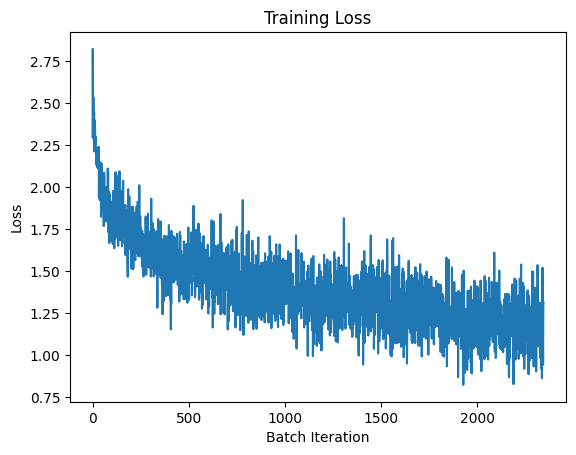

In [17]:
# Now, we can plot our training loss
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Batch Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## Learning Rate
Learning rate will determine how large the step will be in our optimization process. Think back to the gradient descent process. The update rule for the most basic version of gradient descent is:

$$
x_{n+1} = x_{n} - \eta \nabla f(x)
$$

where:
- $x_{n+1}$ are the parameters in the next iteration $n+1$
- $x_n$ are the current parameters at iteration $n$
- $\eta$ is the learning rate
-  $f'(x)$ is the gradient of our loss/cost function

Breaking this down, we are using the gradient of our loss function and our current weights $x_n$ to update the weights $x_{n+1}$ in our next iteration.

Too large of a step size can cause your training process to be very unstable, jumping over local minima and taking a long time to converge. Too small of a step size can also cause it to take very long to converge, especially when the gradient is small. Learning rate is not really machine dependent, but is very important in a successful training.

### Let's look at this in code. We will modify our optimizer to use different learning rates

[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [18]:
# Let's try training
model = MyNetwork().to(device)

learning_rate = 0.001 # Default learning rate for Adam

loss_fn = nn.CrossEntropyLoss() # Initialize our loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Initialize our optimizer

# Training
train_loss = train(train_dataloader, model, loss_fn, optimizer, device)

# Testing
test(test_dataloader, model, loss_fn, device)

loss: 2.297098  [   64/50000]
loss: 1.755377  [ 6464/50000]
loss: 1.507789  [12864/50000]
loss: 1.569269  [19264/50000]
loss: 1.480388  [25664/50000]
loss: 1.585066  [32064/50000]
loss: 1.557698  [38464/50000]
loss: 1.421312  [44864/50000]

Test Error: 
 Accuracy: 50.2%, Avg loss: 1.388597 



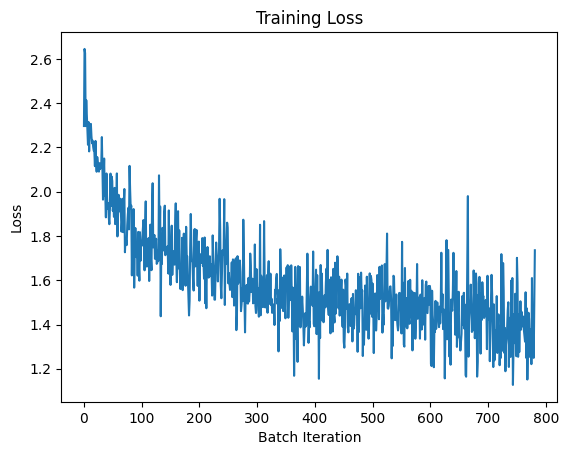

In [19]:
# Now, we can plot our training loss
plt.plot(range(len(train_loss)), train_loss)
plt.xlabel("Batch Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()